# 4. Neural Network Implementation: Plotting a Decision Boundary

In this section, we will implement forward propagation and backpropagation to plot a **decision boundary** on a classification problem. A decision boundary is a line that separates one class from another. In the graph below, the red and blue points represent a different class. We can draw a well-defined decision boundary that separates the two classes. Our program will classify any points above the line as being in the red class, and any points below as being in the blue class.

However, the graph below is a rather simple example since you can draw a linear (straight) line to separate the two classes. There are simpler techniques that can accomplish such a task, such as logistic regression. (Logistic regression is a type of classification algorithm that can only classify things linearly.) Neural networks are more suited with problems in which a **nonlinear** decision boundary is needed.

In [1]:
%cd Images

C:\Users\Chananchida\Documents\Internship\Images


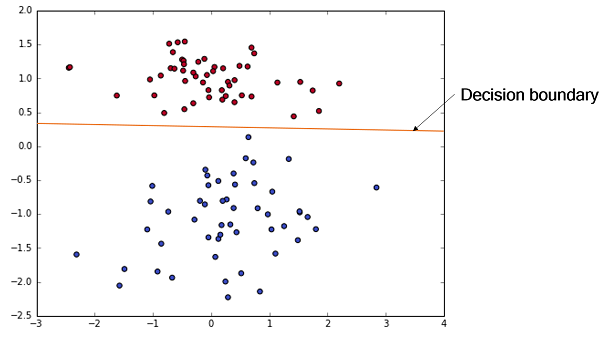

In [2]:
from IPython.display import Image
# Graph 1
Image('decisionboundary.png')

In [3]:
# Import packages for later use
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

# To keep the plots inside the notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

## Constructing a dataset

We will construct a dataset of points using the sklearn.datasets module. Scikit-learn is a Python library used for machine learning. The sklearn.datasets module includes a wide variety of utilities to load and generate datasets. Examples of popular datasets include handwriting classification, housing prices, and face images. It also includes functions which can generate data for classification or clustering problems.

For our implementation, we will construct a dataset that requires a nonlinear boundary decision in which algorithms like logistic regression would not work well. We will do this using the make_gaussian_quantiles function. <sub>(Quantile is just a fancy word for group.)</sub> What the code below does is create two groups of points (each group containing two classes) and join them together (Graph 2).

The green points represent class 1, and the yellow points represent class 2. We will attempt to draw a line which separates the two classes.

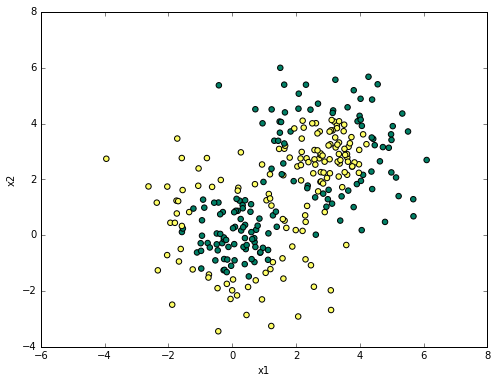

In [4]:
# Graph 2: Constructomg dataset
# Code by Noel Dawe

X1, y1 = sklearn.datasets.make_gaussian_quantiles(cov=2., n_samples=150, n_features=2,
                                                 n_classes=2, random_state=1)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=150, n_features=2,
                                            n_classes=2, random_state=1)

# Join the two datasets
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2+1))

plt.scatter(X[:, 0], X[:, 1],c=y, s=30, cmap=plt.cm.summer)
plt.xlabel('x1')
plt.ylabel('x2')

## Test on Logistic Regression

Logistic regression is one of the most essential techniques used in classification problems. It also uses the sigmoid function, but it is a simpler model than the neural network. Scikit-learn already comes with a built-in implementation of logistic regression, so we are going to use that to classify our dataset.

A decision boundary with color-coded regions is plotted by the plot_decision_boundary function. (Don't worry too much if you don't understand the code - I'm just trying to show that a straight line won't classify the points in our dataset very well.) In this case, our algorithm classifies any point in the green region as being in class 1, and any point in the yellow region in class 2. As you can see, it is not a very good fit of our data.

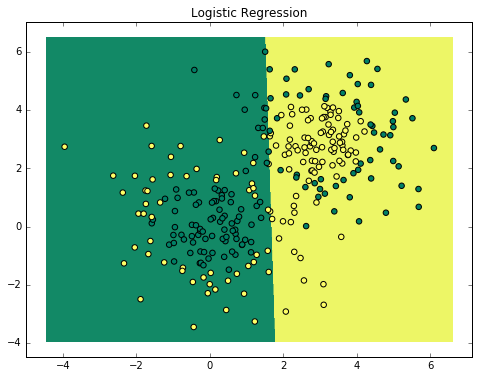

In [5]:
# Graph 3
# Code by Denny Britz

clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.summer)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.summer)
    
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

## Network Architecture

Before we start, we need to have the basic idea of what our network is going to look like.

The number of input nodes corresponds to the number of inputs. In our case, our input is the coordinates $x_{1}, x_{2}$ on a graph, so we will have two input nodes. Don't forget, however, that we will have to include a bias unit $x_{0}$.

The number of output nodes corresponds to the number of classes. We have two classes - yellow and green, so we will need two output nodes. (We could also get away with using only one output node, but using two nodes provide a better foundation to extend our network to problems with more than 2 classes to classify.)

There is no way to accurately determine how many hidden layers or hidden nodes we will need. The rule of thumb is to start off with one hidden layer, so that is what we are going to do. We are going to vary the number of hidden nodes and determine it by trial-and-error.

So far, our network looks like Figure 1.

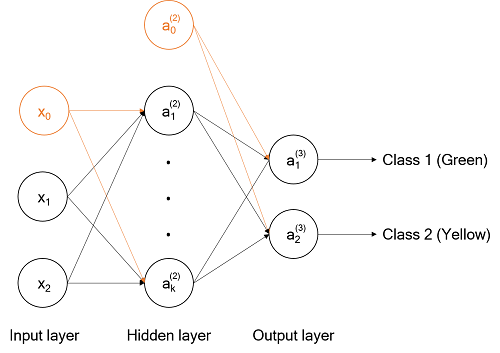

In [6]:
Image('implementation.png')

## Helper Functions

### Transforming y

There is still one more thing we have to do. Currently, we have $y$ as a vector (dimension: $m \times 1$, with $m$ being the number of training examples) consisting of only 0's and 1's, as shown below. (0 is the green class, 1 is the yellow class.)

In [7]:
print(y)

[1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1
 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1
 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0
 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1
 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0
 1 1 0 0]


This arrangement is akin to having only one output node which outputs either a 0 or 1. Recall that we would like two output nodes, and to do that, we have to transform our vector $y$ into a matrix of dimension $m \times 2$.

For a training example, $i$, we define  $ y^{(i)} =  \begin{bmatrix} 1 & 0 \end{bmatrix} $ if the example is class 1 (green), and $ y^{(i)} =  \begin{bmatrix} 0 & 1 \end{bmatrix} $ if the example is class 2 (yellow). The function changey does that in the code below.

In [8]:
def changey(y):
    '''Changes vector y into a matrix of vectors.'''
    m = np.shape(y)[0]
    ynew = np.zeros((m,2))

    for i in np.arange(m):
        ynew[i][y[i]] = 1
    
    return ynew

print(changey(y))

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]

### Cost Function

Now, let's implement our cost function. The cost function is measures the error between our network's prediction and the actual output. It is not necessary for our algorithm as a whole, but keeping track of errors over time will help us know if our network is being trained in the right direction. We expect the cost to decrease the more iterations we train our network. Recall that we are using the cross-entropy loss function,

$$ J(z) = -y\log(g(z)) - (1-y)\log(1-(g(z)))$$

with $g(z)$ being the sigmoid function,

$$g(z) = \frac{1}{1+e^{-z}}$$

in which we would also need to code.

Our network's prediction would be the activation values in the output layer, $a_{1}^{(3)}$ and $a_{2}^{(3)}$. So we would also have to perform forward propagation to get those values.

In [9]:
def sigmoid(x):
    '''Returns the sigmoid of a matrix or real number x'''
    z = np.exp(-x)
    return 1/(1+z)

def costFunction(model, X, y):
    '''Returns the error between the predicted output and actual output'''
    
    # Initialization - get weights
    w1, w2 = model['w1'], model['w2']
    m = np.shape(y)[0]
    
    # Add x0 term (bias unit) to input, transform y
    X = np.insert(X,0,1,axis=1)
    y = changey(y)

    # Forward propagation to get predicted output
    z2 = X.dot(w1.transpose())
    a2 = sigmoid(z2)        

    a2 = np.insert(a2,0,1,axis=1)    # Add a bias unit in hidden layer
    
    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    # Cost function over all training examples
    J = 0
    for i in range(m):
        J += -sum((y[i]*np.log(a3[i]) + (1-y[i])*np.log(1-a3[i])))
    
    return J/m

### Prediction function

The activation values represent the **probability** in which the point is of a certain class. For example, if for a certain training example we have $a_{1}^{(3)} = 0.80$ and $a_{2}^{(3)}=0.20$. This means that there is an 80% probability that the point is green and a 20% probability that the point is yellow. We would always want our network to choose the class with the higher probability, which is what the 'predict' function does.

In [10]:
def predict(model, X):
    '''Outputs the most probable classification'''
    
    # Get weights
    w1, w2 = model['w1'], model['w2']
    
    # Add bias unit
    X = np.insert(X,0,1,axis=1)
    
    #Forward propagation
    z2 = X.dot(w1.transpose())     
    a2 = sigmoid(z2)
    
    # Add bias unit
    a2 = np.insert(a2,0,1,axis=1)  
    
    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    # Get the node with the highest probability
    max_array = np.argmax(a3, axis=1)
    
    return max_array

### Random weight initialization

In neural networks, it is a good idea to randomly initialize the weights to small values. Initializing them all to zero would result in the nodes performing the same calculations to one another, so it wouldn't be a very good network.

In [11]:
def randInitializeWeights(nodes_in, nodes_out):
    '''Randomly initializes a weight matrix'''
    w = np.random.randn(nodes_out, nodes_in+1)
    w /= np.sqrt(nodes_in)
    
    return w

A little note on the dimensions of the weight matrices. Suppose our network has 3 hidden nodes. It would look like this:

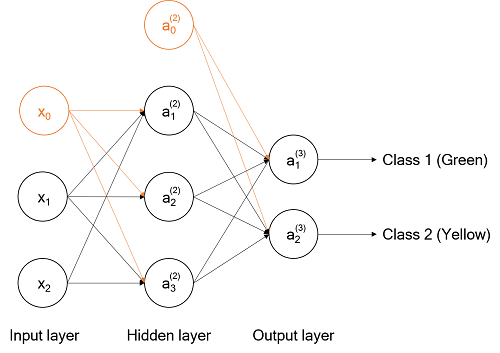

In [12]:
Image('implementation2.png')

Our matrix $w^{(1)}$ is a $3 \times 3$ matrix:

$$
w^{(1)} =
\begin{bmatrix}
w_{10}^{(1)} & w_{11}^{(1)} & w_{12}^{(1)} \\ 
w_{20}^{(1)} & w_{21}^{(1)} & w_{22}^{(1)} \\ 
w_{30}^{(1)} & w_{31}^{(1)} & w_{32}^{(1)} 
\end{bmatrix}
$$

And $w^{(2)}$ is a $2 \times 4$ matrix:
$$
w^{(2)} =
\begin{bmatrix}
w_{10}^{(1)} & w_{11}^{(1)} & w_{12}^{(1)} & w_{13}^{(1)} \\ 
w_{20}^{(1)} & w_{21}^{(1)} & w_{22}^{(1)} & w_{23}^{(1)}
\end{bmatrix}
$$

Let's denote $s_{l}$ as the number of nodes in layer $l$ (excluding the bias unit). For our network, $s_{1}=2, s_{2}=3,$ and $s_{3}=2$. For weights in layer $l$, $w^{(l)}$ has dimensions $(s_{l+1}) \times (s_{l}+1)$.

## Backpropagation

Let's repeat the backpropagation algorithm in the previous section but modify it to fit our network:

1. **Input:** Set $a^{(1)} = x$

2. **Forward propagation:** Compute activations $a^{(2)}$ and $a^{(3)}$.

3. **Compute output error:** $\delta^{(3)} = a^{(3)} - y$

4. **Backpropagate the error:** Compute $\delta^{(2)}$ (explained more below).

5. **Compute gradient(s):** $\frac{\partial J}{\partial w^{(1)}} =  a^{(1)} \delta^{(2)}; \quad
\frac{\partial J}{\partial w^{(2)}} = a^{(2)} \delta^{(3)}$

From the previous section, the equation for computing $\delta^{(2)}$ was 
$$
\delta_{j}^{(2)} = \sum_{i}w_{ij}^{(2)} \delta_{i}^{(3)} \cdot g'(z_{j}^{(2)})
$$

This is a bit messy to implement, so we'll just use matrix multiplication to do the job.

$$\delta^{(2)} =  \delta^{(3)}w^{(2)} \odot g'(z^{(2)})$$

where $\odot$ means elementwise multiplication of the matrices.

In [13]:
def Backpropagation(model, X, y):
    '''Performs backpropagation on the model'''
    # Initialization
    w1, w2 = model['w1'], model['w2']
    m = np.shape(y)[0]
    
    # Add x0 term (bias unit) to input, transform y
    X = np.insert(X,0,1,axis=1)
    y = changey(y)

    # Forward propagation
    z2 = X.dot(w1.transpose())
    a2 = sigmoid(z2)        

    a2 = np.insert(a2,0,1,axis=1)    # Add bias unit

    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    # Backpropagation
    delta3 = a3 - y
    delta2 = delta3.dot(w2) * (a2*(1-a2))
    
    # Remove bias unit
    delta2 = np.delete(delta2,0,axis=1)
    
    # Compute gradients
    w1_grad = delta2.transpose().dot(X) /m
    w2_grad = delta3.transpose().dot(a2) /m
    
    return w1_grad, w2_grad

## Gradient Descent

We can use the partial derivatives obtained from backpropagation in gradient descent:

$$
repeat \ until \ convergence: \\
\quad w_{j, new} := w_{j} - \alpha \frac{\partial J}{\partial w_{j}}
$$

We would have to do this for two sets of weights, $w^{(1)}$ and $w^{(2)}$. Instead of defining a new function, we will just include the code for gradient descent in the main function, NeuralNetworks.

## Putting it All Together

Now, it's time to build our neural network! Let's repeat the learning algorithm from the previous section:

1. Randomly initialize weights.
2. For each training example:
    - **Forward propagation** to compute activations $a^{(2)}, a^{(3)}$.
    - **Backpropagation** to compute gradients (partial derivatives) $\frac{\partial J}{\partial w^{(1)}}, \frac{\partial J}{\partial w^{(2)}}$.
3. Use **gradient descent** (or other optimization algorithms) to minimize the cost function with parameters $w$.

In [14]:
def NeuralNetworks(X, y, hidden_nodes, iterations, print_loss = False):
    '''A 3-layer neural network, returns the optimized weights'''
    
    # Randomly initialize weights
    w1 = randInitializeWeights(np.shape(X)[1], hidden_nodes)
    w2 = randInitializeWeights(hidden_nodes, 2)
    
    # Create model, set learning rate
    model = {'w1':w1, 'w2':w2}
    alpha = 0.05

    for i in range(iterations):
        
        # Backpropagation
        w1_grad, w2_grad = Backpropagation(model, X, y)
        
        # Gradient Descent
        w1 += -alpha*w1_grad
        w2 += -alpha*w2_grad
        
        # Update model
        model = {'w1':w1, 'w2':w2}
        
        # Print cost function every 10000 iterations
        if print_loss:
            if i%10000==0:
                J = costFunction(model, X, y)
                print('Iteration: {}, Cost: {}'.format(i, J))
    
    return model
    

That's it! This is the most basic implementation of neural networks. Let's see how well it does with plotting a decision boundary. The default settings are of 5 nodes in the hidden layer. Try playing around with the number of nodes and see the difference!

Iteration: 0, Cost: 1.5435109645816887
Iteration: 10000, Cost: 1.0225962583107928
Iteration: 20000, Cost: 0.7273531576367578
Iteration: 30000, Cost: 0.6123798872218253
Iteration: 40000, Cost: 0.5888160263832544
Iteration: 50000, Cost: 0.5747516725826644
Iteration: 60000, Cost: 0.5612868096781806


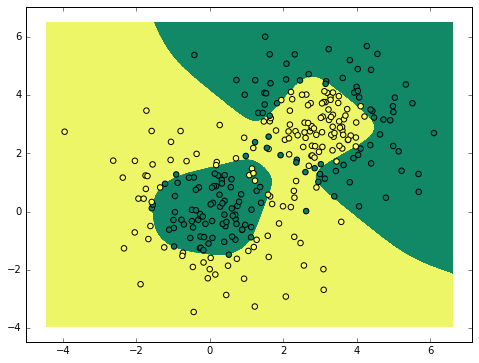

In [15]:
#############################################
# Trying changing the number of hidden nodes!
hidden_nodes = 5
#############################################

model = NeuralNetworks(X, y, hidden_nodes, 70000, print_loss=True)
plot_decision_boundary(lambda x: predict(model, x))

Not too bad! Keep in mind that there are several ways to still improve the performance of our network, two of which are regularization and cleverly initializing weights. They aren't that difficult to implement, but it might be too heavy for this already code-ridden section.

## References & Further Readings

- [Python Notebook Files](https://github.com/csangara/Neural-Networks)
- [Coursera: Machine Learning](https://www.coursera.org/learn/machine-learning)
- [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
- [Logistic Regression](https://codesachin.wordpress.com/2015/08/16/logistic-regression-for-dummies/)
- [Scikit Dataset Loading Utilities](http://scikit-learn.org/stable/datasets/)
- [Scikit Learn API Reference](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)